# Working Notebook 1

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LassoLars, TweedieRegressor

import env

# Acquire data

In [2]:
def get_zillow_data():
        ''' Acquire Zillow data using properties_2017 table from Code up Data Base. Columns bedroomcnt, 
            bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips 
        '''
   
         # sql query for acquisition
        sql_query = """
        SELECT calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt,yearbuilt, fireplacecnt,
        decktypeid, poolcnt, garagecarcnt

        FROM properties_2017
        LEFT JOIN propertylandusetype USING(propertylandusetypeid)
        LEFT JOIN predictions_2017 USING(parcelid)
        WHERE (propertylandusetype.propertylandusedesc LIKE ('%%Single%%')) 
            AND (predictions_2017.transactiondate like '2017%%');
        """
        # Acquisition
        df = pd.read_sql(sql_query, env.get_connection('zillow'))
        return df

In [3]:
# had to adress % by using %% so it could be read by notebook

In [4]:
# import data
df = get_zillow_data()

In [5]:
# 52441 observations
df.shape

(52441, 9)

In [6]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  52359 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   bedroomcnt                    52441 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
 4   yearbuilt                     52325 non-null  float64
 5   fireplacecnt                  7243 non-null   float64
 6   decktypeid                    389 non-null    float64
 7   poolcnt                       11096 non-null  float64
 8   garagecarcnt                  18015 non-null  float64
dtypes: float64(9)
memory usage: 3.6 MB


In [7]:
df.isnull().sum().sort_values()

bathroomcnt                         0
bedroomcnt                          0
taxvaluedollarcnt                   1
calculatedfinishedsquarefeet       82
yearbuilt                         116
garagecarcnt                    34426
poolcnt                         41345
fireplacecnt                    45198
decktypeid                      52052
dtype: int64

<div class="alert alert-info"> 
roomcnt                          0
    
fips                             0
    
regionidcounty                   0
    
latitude                         0
    
propertycountylandusecode        0
    
longitude                        0
    
regionidzip                     26
    
yearbuilt                      116
    
fullbathcnt                    137
    
calculatedbathnbr              137

I could maybe add one of these to explorations
    

In [8]:
df.dtypes

calculatedfinishedsquarefeet    float64
bathroomcnt                     float64
bedroomcnt                      float64
taxvaluedollarcnt               float64
yearbuilt                       float64
fireplacecnt                    float64
decktypeid                      float64
poolcnt                         float64
garagecarcnt                    float64
dtype: object

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calculatedfinishedsquarefeet,52359.0,1922.890754,1004.365838,128.0,1268.0,1659.0,2306.00,21929.0
bathroomcnt,52441.0,2.299403,1.022772,0.0,2.0,2.0,3.00,18.0
bedroomcnt,52441.0,3.300681,0.949094,0.0,3.0,3.0,4.00,14.0
taxvaluedollarcnt,52440.0,529688.163921,751894.553363,1000.0,193747.5,373612.0,619301.25,49061236.0
yearbuilt,52325.0,1963.393884,23.133571,1878.0,1950.0,1961.0,1979.00,2016.0
fireplacecnt,7243.0,1.209858,0.512885,1.0,1.0,1.0,1.00,5.0
decktypeid,389.0,66.000000,0.000000,66.0,66.0,66.0,66.00,66.0
poolcnt,11096.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
garagecarcnt,18015.0,1.948987,0.549944,0.0,2.0,2.0,2.00,14.0


<div class="alert alert-info"> There seems to be bathrooms/ bedrooms with min of 0 and max above what ight be consider a single family dweling

In [10]:
# rename columns
df = df.rename(columns={'bedroomcnt': 'bedrooms','bathroomcnt': 'bathrooms',
            'calculatedfinishedsquarefeet': 'squarefeet','taxvaluedollarcnt': 'home_value',
                        'lotsizesquarefeet':'lot','fireplacecnt': 'fireplace','decktypeid':'deck','poolcnt':'pool',
                       'garagecarcnt':'garage'})

In [11]:
def process_fancy_features(df, feature):
    df[feature]=df[feature].replace(r"^\s*$", np.nan, regex=True)
    if df[feature]:
        df[feature] == 1
    else:
        df[feature].fillna(0)
    return df[feature].isnull().sum()

In [12]:
df.garage 

0        2.0
1        2.0
2        NaN
3        NaN
4        2.0
        ... 
52436    NaN
52437    NaN
52438    NaN
52439    NaN
52440    2.0
Name: garage, Length: 52441, dtype: float64

In [13]:
df.isnull().sum()

squarefeet       82
bathrooms         0
bedrooms          0
home_value        1
yearbuilt       116
fireplace     45198
deck          52052
pool          41345
garage        34426
dtype: int64

In [14]:
fancy_features = ['fireplace','deck','pool','garage']

In [15]:
def process_fancy_features(df, feature):
    df[feature]=df[feature].replace(r"^\s*$", np.nan, regex=True)     
    # fill fancy features with 0 assumption that if it was not mark it did not exist
    df[feature] = df[feature].fillna(0)
    return df

In [16]:
for i in fancy_features:
    process_fancy_features(df, i)

These values were filled in with 0 since the presense was not anotated it is assumed it does not exist

fireplace     45198

deck          52052

pool          41345

garage        34426

In [17]:
# still have 82 nulls in square feet and 116 nulls in yearbuilt and 1 null in home_value
df.isnull().sum()

squarefeet     82
bathrooms       0
bedrooms        0
home_value      1
yearbuilt     116
fireplace       0
deck            0
pool            0
garage          0
dtype: int64

In [18]:
df.describe()

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage
count,52359.000000,52441.000000,52441.000000,5.244000e+04,52325.000000,52441.000000,52441.000000,52441.00000,52441.000000
mean,1922.890754,2.299403,3.300681,5.296882e+05,1963.393884,0.167102,0.489579,0.21159,0.669533
std,1004.365838,1.022772,0.949094,7.518946e+05,23.133571,0.458887,5.663314,0.40844,0.980074
min,128.000000,0.000000,0.000000,1.000000e+03,1878.000000,0.000000,0.000000,0.00000,0.000000
25%,1268.000000,2.000000,3.000000,1.937475e+05,1950.000000,0.000000,0.000000,0.00000,0.000000
50%,1659.000000,2.000000,3.000000,3.736120e+05,1961.000000,0.000000,0.000000,0.00000,0.000000
75%,2306.000000,3.000000,4.000000,6.193012e+05,1979.000000,0.000000,0.000000,0.00000,2.000000
max,21929.000000,18.000000,14.000000,4.906124e+07,2016.000000,5.000000,66.000000,1.00000,14.000000


## outliers

In [19]:
def handle_outliers(df):
    """Manually handle outliers '"""
    df = df[df.bathrooms <= 6]
    
    df = df[df.bedrooms <= 6]
    
    df = df[df.home_value <= 1_750_000]
    
    return df


In [20]:
df.shape

(52441, 9)

In [21]:
(51918-1632)/(52441)

0.9589061993478385

In [22]:
1632/ 52441

0.031120688011288877

In [23]:
# removed homes above 1_750_000 as outliers total of 1632 rows about 3% of data still retain .958 of original dat
df[df.home_value > 1_750_000]

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage
53,4503.0,5.5,5.0,2349388.0,2003.0,0.0,0.0,0.0,3.0
96,10686.0,8.0,6.0,1936396.0,1995.0,0.0,0.0,0.0,0.0
111,3287.0,4.0,3.0,2016514.0,2002.0,0.0,0.0,1.0,0.0
200,3681.0,4.0,5.0,1850800.0,1993.0,0.0,0.0,1.0,2.0
206,3407.0,4.0,4.0,2311622.0,2007.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
52347,1376.0,2.0,3.0,3350325.0,1923.0,0.0,0.0,0.0,0.0
52379,2380.0,2.0,3.0,2254064.0,1923.0,0.0,0.0,1.0,0.0
52385,5945.0,6.0,5.0,2912659.0,2012.0,0.0,0.0,1.0,0.0
52408,4530.0,4.0,3.0,1900000.0,1987.0,0.0,0.0,1.0,0.0


In [24]:
pd.options.display.float_format = '{:,.3f}'.format
df. home_value.describe()

count       52,440.000
mean       529,688.164
std        751,894.553
min          1,000.000
25%        193,747.500
50%        373,612.000
75%        619,301.250
max     49,061,236.000
Name: home_value, dtype: float64

In [25]:
52112/52441

0.9937262828702733

In [26]:
52112-52441

-329

In [27]:
df = handle_outliers(df)

# nulls and 0

In [28]:
df.isnull().sum()

squarefeet    53
bathrooms      0
bedrooms       0
home_value     0
yearbuilt     86
fireplace      0
deck           0
pool           0
garage         0
dtype: int64

In [29]:
df[df.squarefeet.isnull()]

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage
1746,NaN,0.000,0.000,"830,145.000",NaN,0.000,0.000,0.000,0.000
2088,NaN,1.000,2.000,"488,078.000",NaN,0.000,0.000,0.000,0.000
3231,NaN,0.000,0.000,"643,406.000",NaN,0.000,0.000,0.000,0.000
4741,NaN,0.000,0.000,"656,601.000",NaN,0.000,0.000,0.000,0.000
5582,NaN,0.000,0.000,"375,218.000","1,932.000",0.000,0.000,0.000,0.000
6616,NaN,0.000,0.000,"178,684.000","1,955.000",0.000,0.000,0.000,0.000
7723,NaN,0.000,0.000,"1,575,136.000",NaN,0.000,0.000,0.000,0.000
8783,NaN,0.000,0.000,"26,405.000",NaN,0.000,0.000,0.000,0.000
8931,NaN,0.000,0.000,"973,624.000",NaN,0.000,0.000,0.000,0.000
9907,NaN,0.000,0.000,"38,206.000",NaN,0.000,0.000,0.000,0.000


In [30]:
# dropped properties with no bathrooms and no bedrooms 153 rows at still retained .990 of original data
df= df[~(df.bathrooms==0) & ~(df.bedrooms ==0)]

In [31]:
df.shape

(50326, 9)

In [32]:
51959 - 52112

-153

In [33]:
51959/52441

0.9908087183692149

In [34]:
df[df['squarefeet'].isnull()]

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage
2088,NaN,1.000,2.000,"488,078.000",NaN,0.000,0.000,0.000,0.000
10651,NaN,1.000,2.000,"400,778.000",NaN,0.000,0.000,0.000,0.000
12491,NaN,1.500,2.000,"719,590.000",NaN,0.000,0.000,0.000,0.000
13155,NaN,1.000,2.000,"107,267.000",NaN,1.000,0.000,0.000,0.000
21204,NaN,1.000,1.000,"390,087.000",NaN,0.000,0.000,0.000,0.000
39042,NaN,4.500,5.000,"1,461,048.000","2,004.000",2.000,0.000,0.000,2.000
44782,NaN,1.000,1.000,"165,899.000",NaN,1.000,0.000,0.000,0.000
44802,NaN,1.000,1.000,"131,534.000",NaN,0.000,0.000,0.000,0.000


In [35]:
df.squarefeet.mean()

1830.7172582376088

In [36]:
df.isnull().sum()

squarefeet     8
bathrooms      0
bedrooms       0
home_value     0
yearbuilt     39
fireplace      0
deck           0
pool           0
garage         0
dtype: int64

In [37]:
# dropped null values in yearbuilt 89 and 1 in home_value still retained .99 of original data.
# total dropped 90, 
df = df.dropna()

In [38]:
df.shape

(50286, 9)

In [39]:
51918/52441

0.9900268873591274

### fireplace

In [40]:
df.fireplace.value_counts()

0.000    43244
1.000     5948
2.000      884
3.000      194
4.000       16
Name: fireplace, dtype: int64

In [41]:
df.fireplace = df.fireplace.replace({2:1, 3:1, 4:1, 5:1})
df.fireplace.value_counts()

0.000    43244
1.000     7042
Name: fireplace, dtype: int64

### garage

In [42]:
df.garage.value_counts()

0.000     32993
2.000     14430
1.000      2174
3.000       507
4.000       147
5.000        20
6.000         7
7.000         3
8.000         2
9.000         1
13.000        1
14.000        1
Name: garage, dtype: int64

In [43]:
df.garage = df.garage.replace({2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 13:1,14:1})
df.garage.value_counts()

0.000    32993
1.000    17293
Name: garage, dtype: int64

### pool

In [44]:
df.pool.value_counts()

0.000    40272
1.000    10014
Name: pool, dtype: int64

In [45]:
df.deck.value_counts()

0.000     49936
66.000      350
Name: deck, dtype: int64

In [68]:
df.deck= df.deck.replace({66:1})
df.deck.value_counts()

0.000    49936
1.000      350
Name: deck, dtype: int64

# New Column

In [69]:
#Creating new column for home age using year_built, casting as float
df['home_age'] = 2017- df['yearbuilt']
df["home_age"] = df["home_age"].astype('float')

# split data for exploration

In [70]:
def split_data(df):
    '''
    split_data takes in data Frame and splits into  train , validate, test.
    The split is 20% test 80% train/validate. Then 30% of 80% validate and 70% of 80% train.
    Aproximately (train 56%, validate 24%, test 20%)
    Returns train, validate, and test 
    '''
    # split test data from train/validate
    train_and_validate, test = train_test_split(df, random_state=123, test_size=.2)

    # split train from validate
    train, validate = train_test_split(train_and_validate, random_state=123, test_size=.3)
                                   
    return train, validate, test

In [71]:
train, validate, test = split_data(df)

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28159 entries, 32888 to 52048
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   squarefeet  28159 non-null  float64
 1   bathrooms   28159 non-null  float64
 2   bedrooms    28159 non-null  float64
 3   home_value  28159 non-null  float64
 4   yearbuilt   28159 non-null  float64
 5   fireplace   28159 non-null  float64
 6   deck        28159 non-null  float64
 7   pool        28159 non-null  float64
 8   garage      28159 non-null  float64
 9   home_age    28159 non-null  float64
dtypes: float64(10)
memory usage: 2.4 MB


In [73]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
squarefeet,"28,159.000","1,834.570",806.534,152.000,"1,257.000","1,633.000","2,233.000","7,434.000"
bathrooms,"28,159.000",2.223,0.884,1.000,2.000,2.000,3.000,6.000
bedrooms,"28,159.000",3.269,0.889,1.000,3.000,3.000,4.000,6.000
home_value,"28,159.000","433,444.353","327,881.978","3,254.000","188,704.500","363,000.000","586,000.000","1,747,105.000"
yearbuilt,"28,159.000","1,963.050",22.750,"1,878.000","1,950.000","1,960.000","1,978.000","2,016.000"
fireplace,"28,159.000",0.141,0.348,0.000,0.000,0.000,0.000,1.000
deck,"28,159.000",0.007,0.085,0.000,0.000,0.000,0.000,1.000
pool,"28,159.000",0.201,0.401,0.000,0.000,0.000,0.000,1.000
garage,"28,159.000",0.344,0.475,0.000,0.000,0.000,1.000,1.000
home_age,"28,159.000",53.950,22.750,1.000,39.000,57.000,67.000,139.000


In [74]:
train.head()

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,home_age
32888,"2,656.000",3.000,4.000,"173,974.000","1,953.000",0.000,0.000,0.000,0.000,64.000
4517,"1,251.000",4.000,4.000,"314,375.000","1,942.000",0.000,0.000,0.000,0.000,75.000
29464,"1,133.000",1.000,3.000,"345,355.000","1,953.000",0.000,0.000,0.000,0.000,64.000
15391,"1,439.000",2.000,4.000,"76,380.000","1,959.000",0.000,0.000,0.000,1.000,58.000
14157,"1,737.000",3.000,4.000,"103,583.000","1,988.000",0.000,0.000,0.000,0.000,29.000


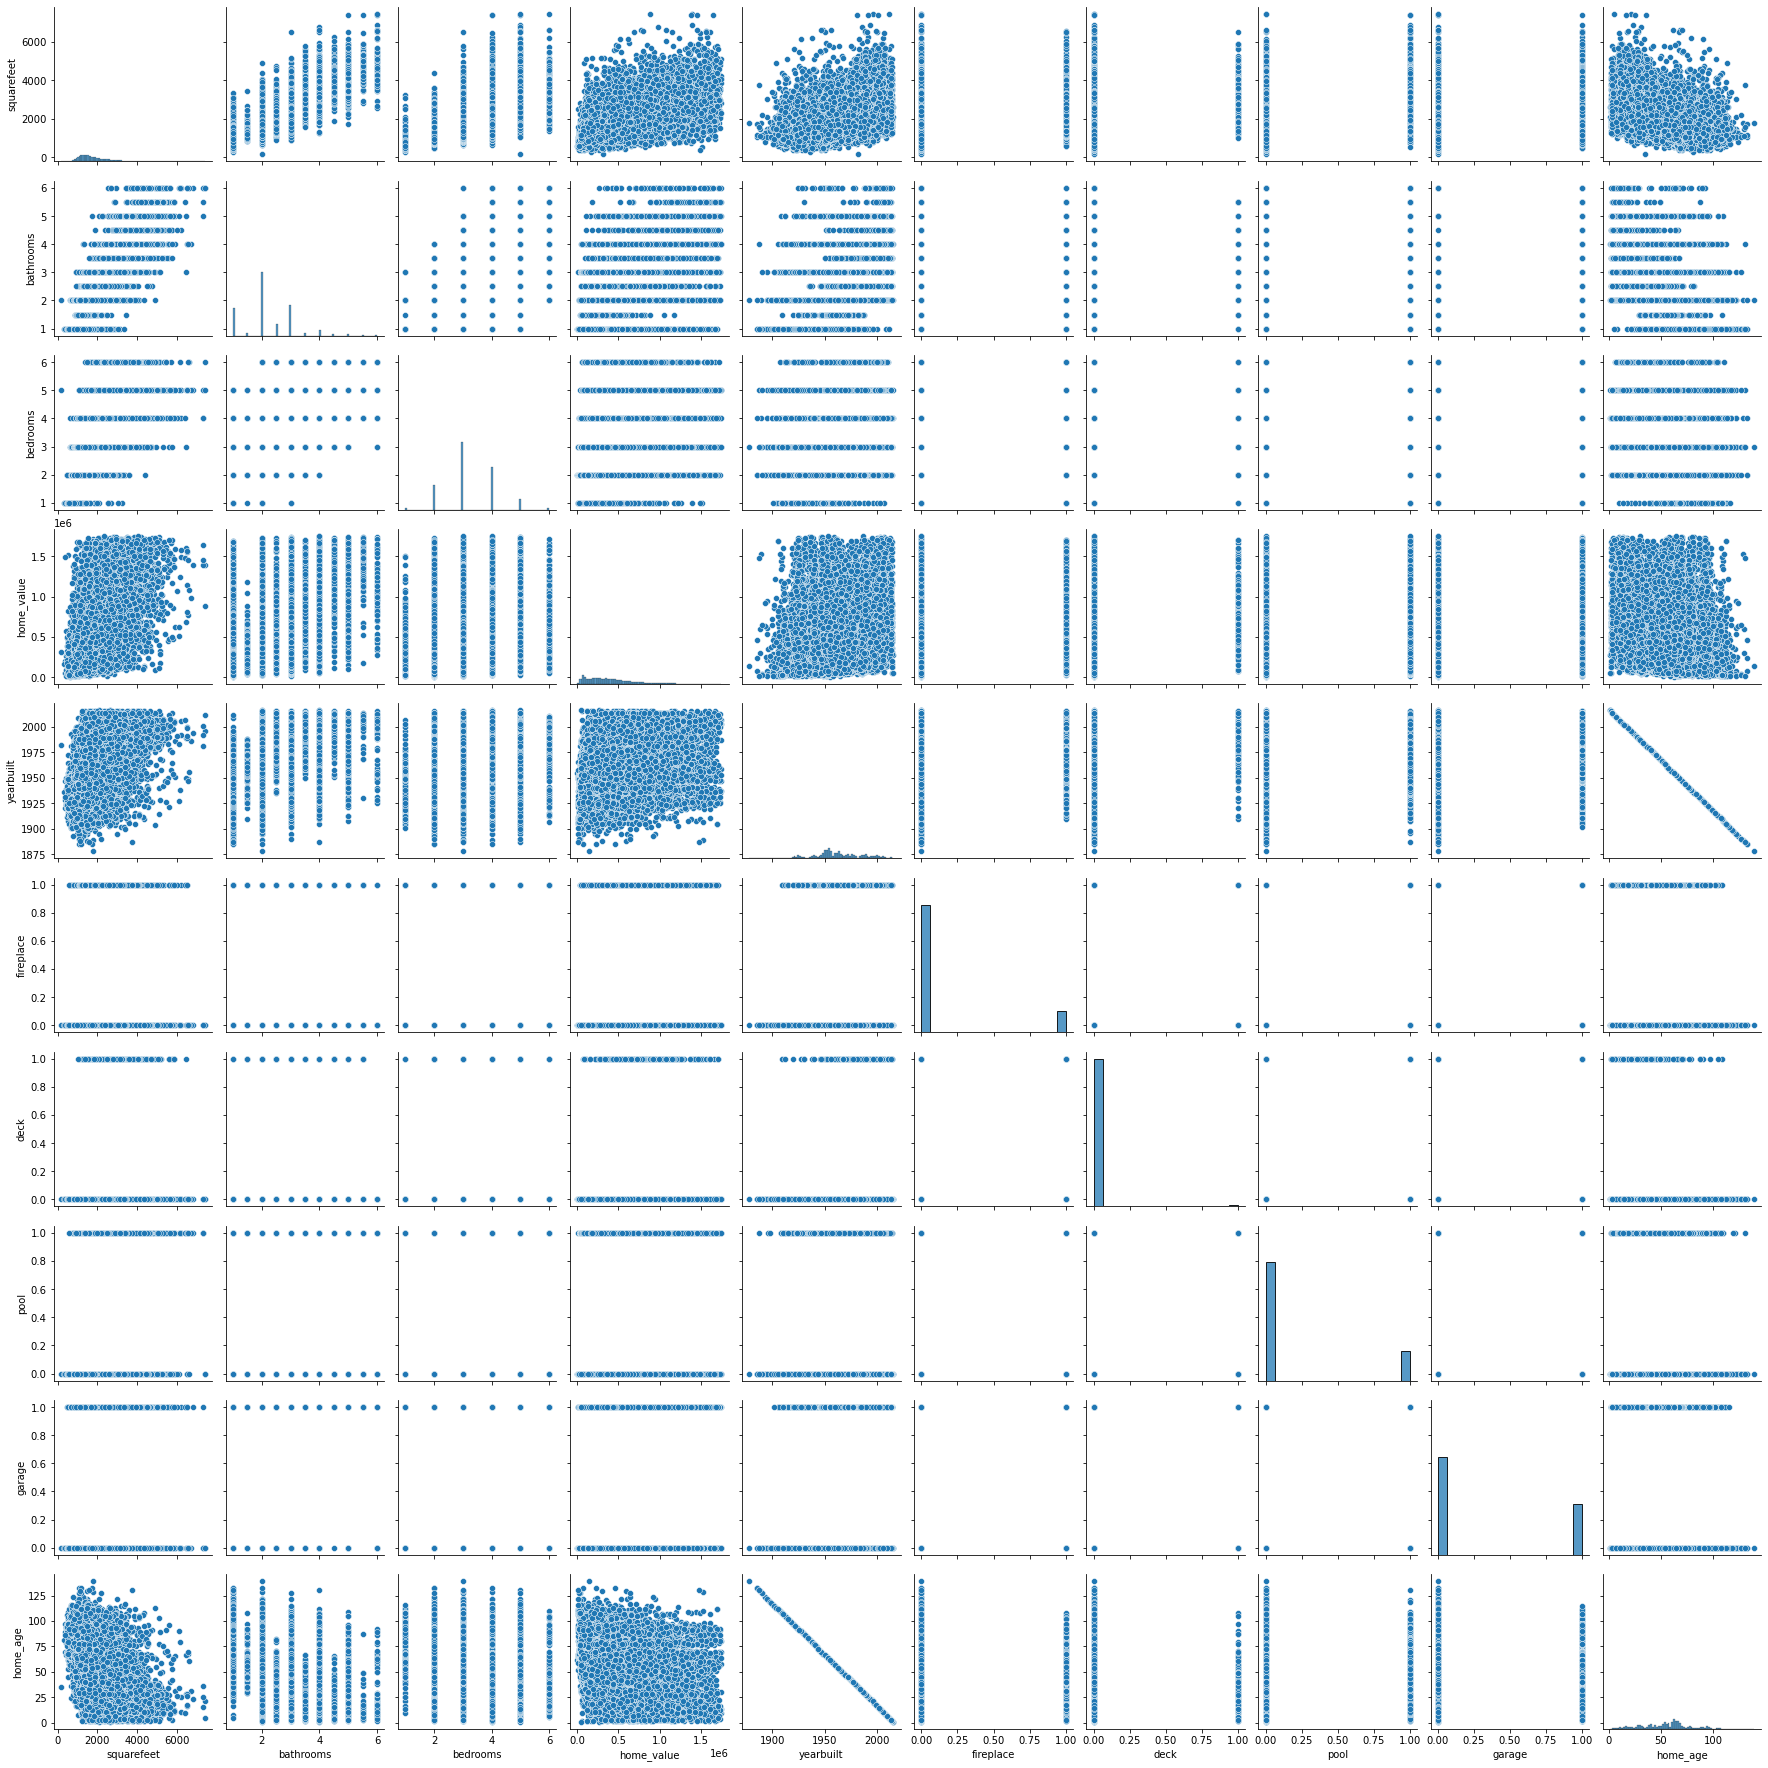

In [75]:
sns.pairplot(train)

In [76]:
# correaltion between variables
zillow_corr = train.corr(method='spearman')
zillow_corr

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,home_age
squarefeet,1.000,0.826,0.659,0.489,0.536,0.172,0.086,0.324,0.222,-0.536
bathrooms,0.826,1.000,0.622,0.450,0.601,0.143,0.077,0.277,0.229,-0.601
bedrooms,0.659,0.622,1.000,0.262,0.436,0.152,0.043,0.237,0.192,-0.436
home_value,0.489,0.450,0.262,1.000,0.272,0.126,0.078,0.219,0.210,-0.272
yearbuilt,0.536,0.601,0.436,0.272,1.000,0.241,0.078,0.120,0.424,-1.000
fireplace,0.172,0.143,0.152,0.126,0.241,1.000,0.187,0.064,0.547,-0.241
deck,0.086,0.077,0.043,0.078,0.078,0.187,1.000,0.022,0.110,-0.078
pool,0.324,0.277,0.237,0.219,0.120,0.064,0.022,1.000,0.036,-0.120
garage,0.222,0.229,0.192,0.210,0.424,0.547,0.110,0.036,1.000,-0.424
home_age,-0.536,-0.601,-0.436,-0.272,-1.000,-0.241,-0.078,-0.120,-0.424,1.000


<AxesSubplot:>

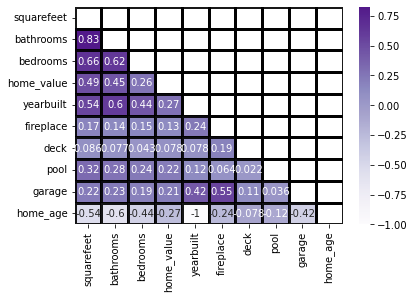

In [77]:
# pass my correlation matrix to Seaborn's heatmap 
kwargs = {'alpha':.9,
          'linewidth':3, 
          'linestyle':'-',
          'linecolor':'black'}
sns.heatmap(zillow_corr, cmap='Purples', annot=True, 
            mask=np.triu(zillow_corr), **kwargs)

In [78]:
train.columns.to_list()

['squarefeet',
 'bathrooms',
 'bedrooms',
 'home_value',
 'yearbuilt',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'home_age']

In [79]:
def plot_variable_pair(df):
    columns = ['squarefeet',
 'bathrooms',
 'bedrooms',
 'home_value',
 'yearbuilt',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'home_age']
    for i, col in enumerate(columns):
        sns.lmplot(data=df, x=col, y='home_value', line_kws={'color':'red'})
        plt.show()

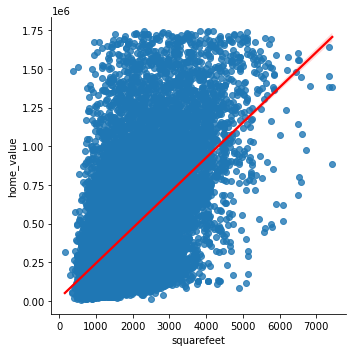

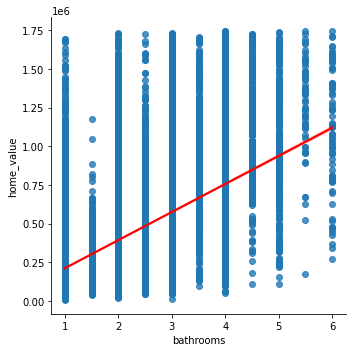

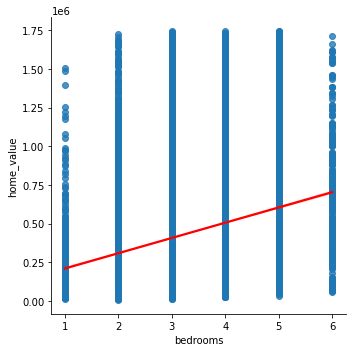

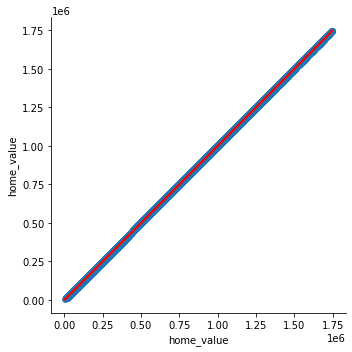

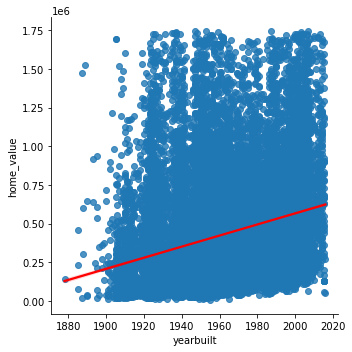

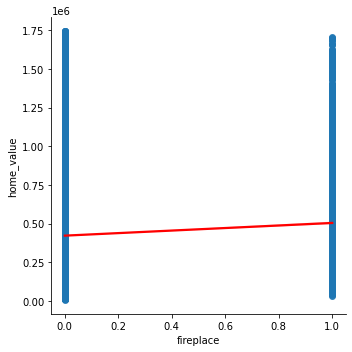

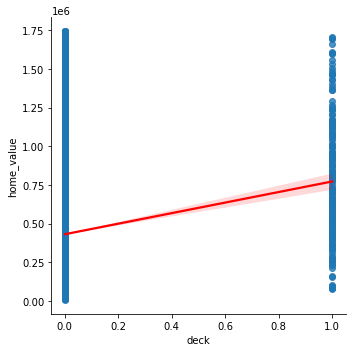

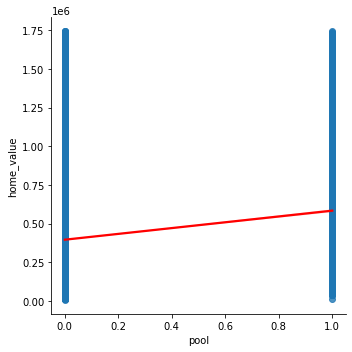

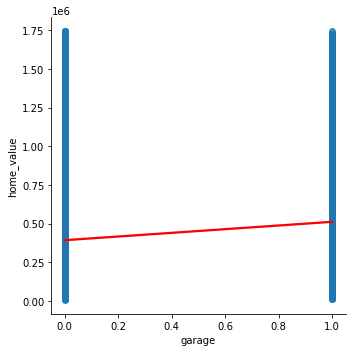

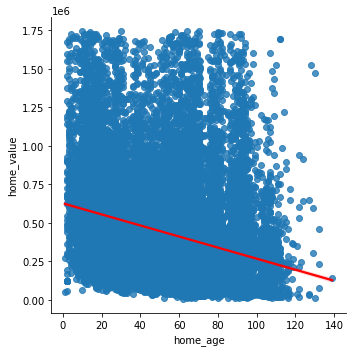

In [80]:
plot_variable_pair(train)

In [81]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            plt.show()

In [82]:
train.columns

Index(['squarefeet', 'bathrooms', 'bedrooms', 'home_value', 'yearbuilt',
       'fireplace', 'deck', 'pool', 'garage', 'home_age'],
      dtype='object')

In [116]:
# set categories
cat_vars =['pool','garage','deck','fireplace', 'bathrooms', 'bedrooms']
cont_vars =['home_value','home_age','squarefeet']

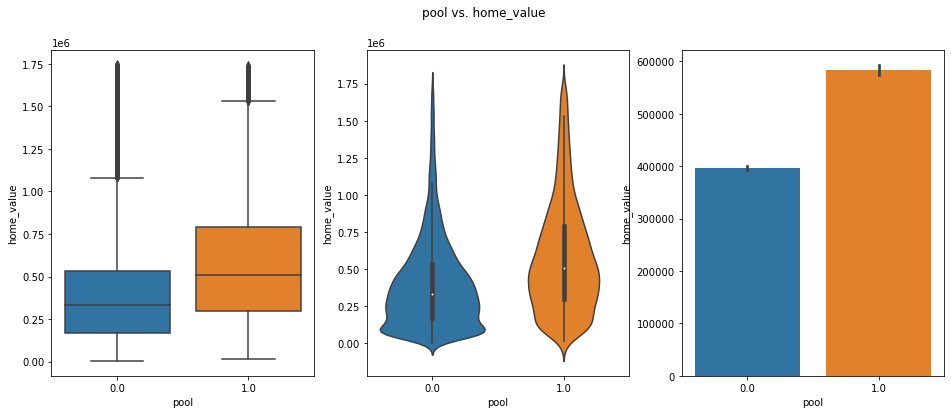

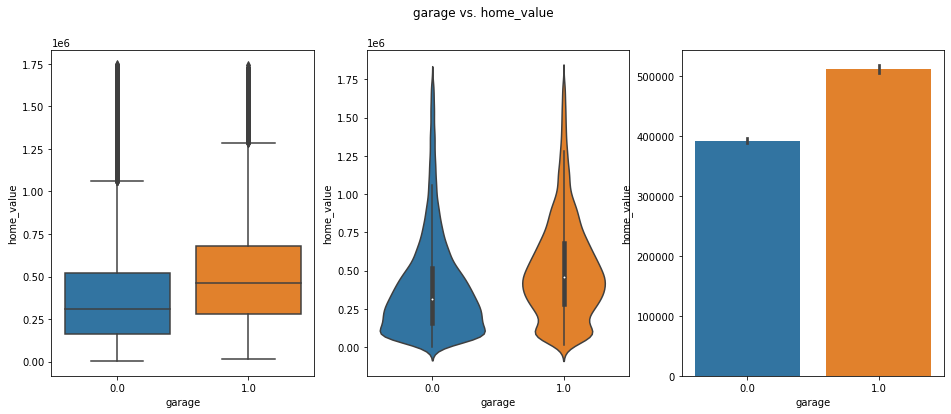

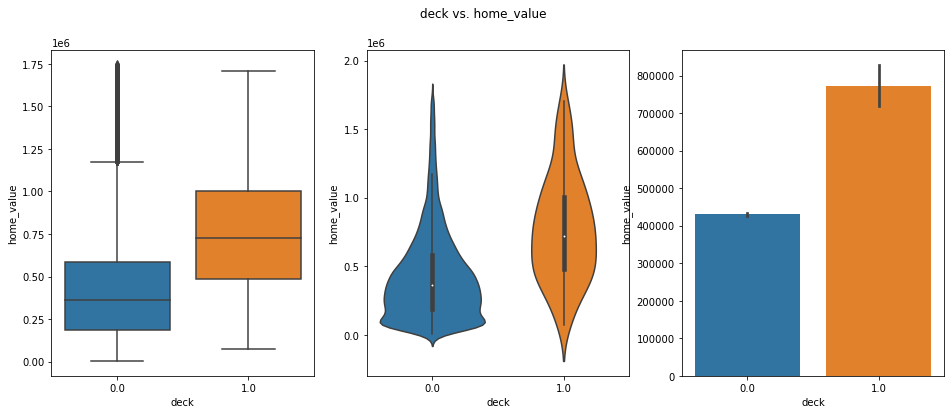

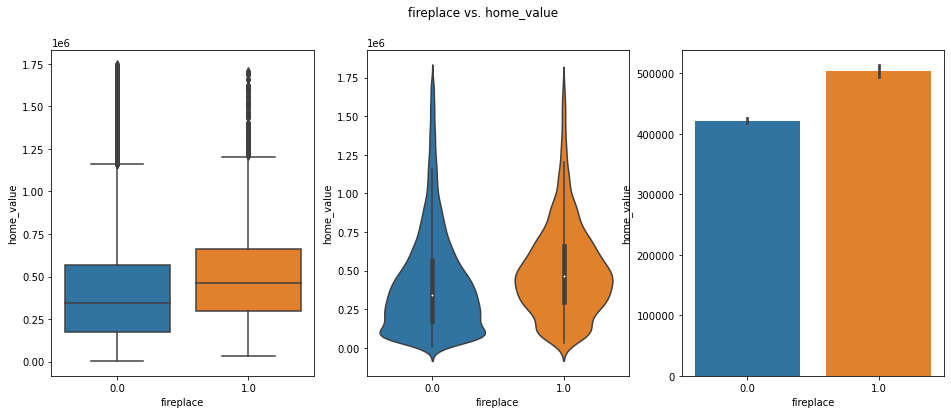

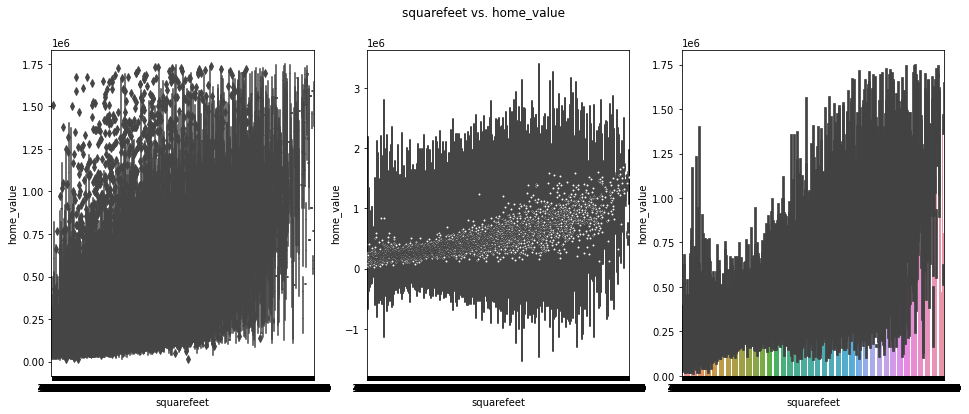

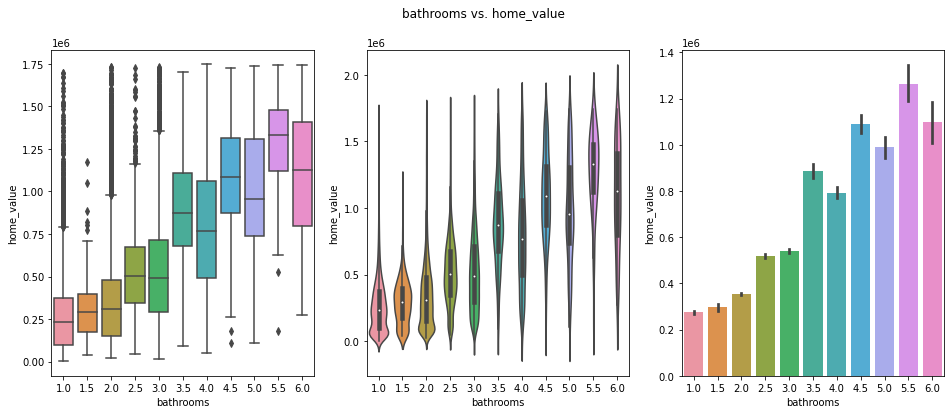

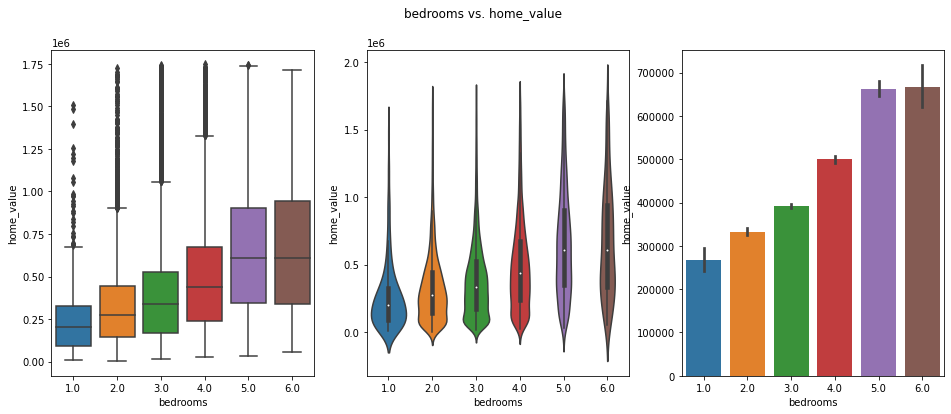

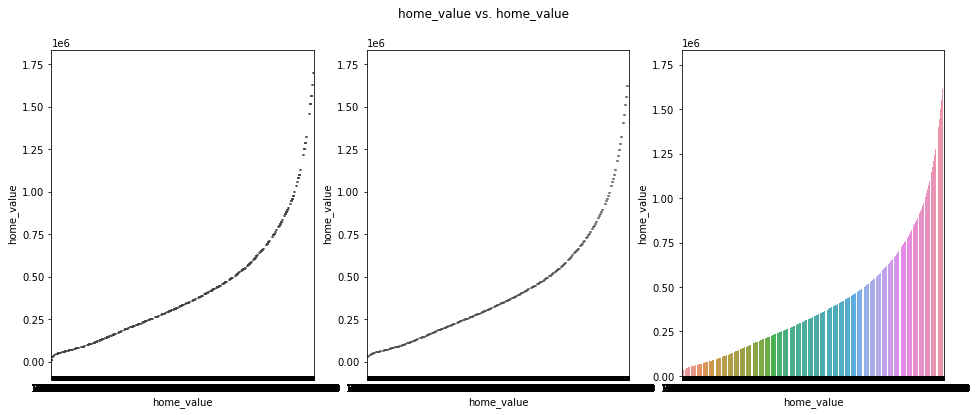

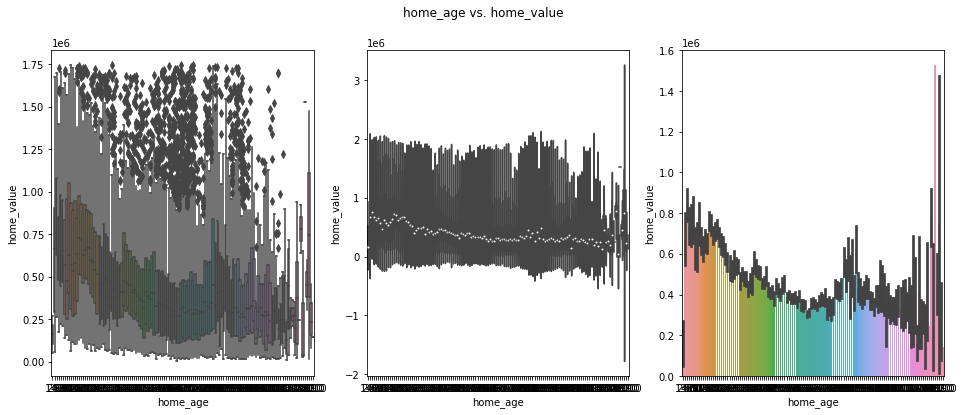

In [115]:
plot_categorical_and_continuous_vars(train, cat_vars, cont_vars)

<div class="alert alert-info">
Home_Value increases with features:
    
    * pool
    
    * garage
    
    * deck
    
    * fireplace
    
    * Square feet
    
    * bathrooms
    
    * Bedrooms

Questions:
       * Answer the following initial question
       
        * What does the average home look like
        
        * Do popular builts have a higher home value than the average built.
        
        * Do properties with more bathrooms have a higher home value? bedrooms? squarefeet?
        
        * What are the average attributes of home whose value that are in the bottom quantile?
        
        * Are one stories home more valuable than two story homes.
        
        * Does having things like pool, deck, fireplace, garage increase home value?
        
        *( maybe look into roomcnt, regionidcounty, propertycountylandusecode, regionzip,fullbathcnt, yearbuilt, calculatedbathbr)

# What does the average home look like?

In [122]:
for i in columns:
    mean = train[i].mean()
    print (f'{i} mean = {mean}')

squarefeet mean = 1834.5699421144216
bathrooms mean = 2.223374409602614
bedrooms mean = 3.2687240313931603
home_value mean = 433444.3529244646
yearbuilt mean = 1963.0503569018786
fireplace mean = 0.14102063283497282
deck mean = 0.007244575446571256
pool mean = 0.20110799389182854
garage mean = 0.3443659220853013
home_age mean = 53.949643098121385


The average home_value is 433,444
The average home is 1835 **squarefeet**, has between 2 to 2.5 **bathrooms**, and 3 **bedrooms**.
About 1 in 3 homes have a **garage** on average
and 1 in 5 homes have a **pool** on average
1 in 7 have a **fireplace**
and less tha 1% have a **deck**


# What is the most popular built?

In [123]:
for i in columns:
    mode = train[i].mode()
    print (f'{i} mode = {mode}')

squarefeet mode = 0   1,120.000
Name: squarefeet, dtype: float64
bathrooms mode = 0   2.000
Name: bathrooms, dtype: float64
bedrooms mode = 0   3.000
Name: bedrooms, dtype: float64
home_value mode = 0   455,000.000
1   600,000.000
Name: home_value, dtype: float64
yearbuilt mode = 0   1,955.000
Name: yearbuilt, dtype: float64
fireplace mode = 0   0.000
Name: fireplace, dtype: float64
deck mode = 0   0.000
Name: deck, dtype: float64
pool mode = 0   0.000
Name: pool, dtype: float64
garage mode = 0   0.000
Name: garage, dtype: float64
home_age mode = 0   62.000
Name: home_age, dtype: float64


The most popular built is a home with 1_120 squarefeet, 2 bathrooms, 3 bedrooms,  

# Do popular builts have a higher home value than others? More house vs minimal house

In [166]:
house = train[ (train.bathrooms ==2)&(train.bedrooms ==3)]
house.shape

(7340, 10)

In [167]:
more_house = train[ (train.bathrooms>2)&(train.bedrooms >3)]

In [168]:
minimal_house = train[(train.bathrooms<2)&(train.bedrooms <3)]

In [169]:
more_house.home_value.median(), minimal_house.home_value.median(), house.home_value.median()

(577083.0, 238989.0, 303030.5)

In [170]:
more_house.home_value.mean(), minimal_house.home_value.mean(), house.home_value.mean()

(632376.3786775415, 278016.0484513953, 350504.5595367847)

# Homes with the ideal amount of bathrooms?

In [171]:
train.bathrooms.median()

2.0

In [172]:
house = train[train.bathrooms == 2]
more_house = train[ train.bathrooms>2]

minimal_house = train[train.bathrooms<2]



In [173]:
more_house.home_value.median(), minimal_house.home_value.median(), house.home_value.median()

(554052.0, 239107.0, 308595.0)

In [174]:
more_house.home_value.mean(), minimal_house.home_value.mean(), house.home_value.mean()

(614007.7589398811, 276235.66856452724, 355598.01396694215)

#  What are the average attributes of home whose value that are in the bottom quantile?

In [187]:
bottom_q = train[train.home_value < train.home_value.quantile(.25)]

In [192]:
bottom_q.bedrooms.mean(), bottom_q.bathrooms.median()

(3.0326704545454546, 2.0)

In [191]:
bottom_q.bathrooms.mean(), bottom_q.bathrooms.median()

(1.8284801136363635, 2.0)

In [190]:
bottom_q.home_value.mean()

103303.45909090909

In [85]:
def show_cat_vs_cont(df, cat_vars=cat_vars, cont_vars=cont_vars):
    print('Categorical vs Continuous Variables:')
    #number = 1
    palettes = ['flare', 'Blues_r', 'PuRd_r', 'Accent']
    for j, cont in enumerate(cont_vars):
        plt.figure(figsize=(20,4))
        plt.suptitle(cont)
        for i, cat in enumerate(cat_vars):
            plt.subplot(1, 4, i+1)
            sns.barplot(data=df, x=cat, y=cont, palette=palettes[j])
            plt.title(cat + ' vs ' + cont)
        plt.show()

In [ ]:
# show_cat_vs_cont(train, cat_vars,cont_vars)

In [194]:
train['fancy_features'] = (train.garage==1)|(train.deck == 1)|(train.pool == 1)|(train.fireplace == 1)

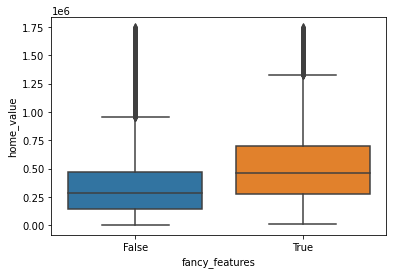

In [199]:
sns.boxplot(data=train, x='fancy_features', y='home_value');

In [195]:
train.head()

,squarefeet,bathrooms,bedrooms,home_value,yearbuilt,fireplace,deck,pool,garage,home_age,fancy_features
32888,"2,656.000",3.000,4.000,"173,974.000","1,953.000",0.000,0.000,0.000,0.000,64.000,False
4517,"1,251.000",4.000,4.000,"314,375.000","1,942.000",0.000,0.000,0.000,0.000,75.000,False
29464,"1,133.000",1.000,3.000,"345,355.000","1,953.000",0.000,0.000,0.000,0.000,64.000,False
15391,"1,439.000",2.000,4.000,"76,380.000","1,959.000",0.000,0.000,0.000,1.000,58.000,True
14157,"1,737.000",3.000,4.000,"103,583.000","1,988.000",0.000,0.000,0.000,0.000,29.000,False


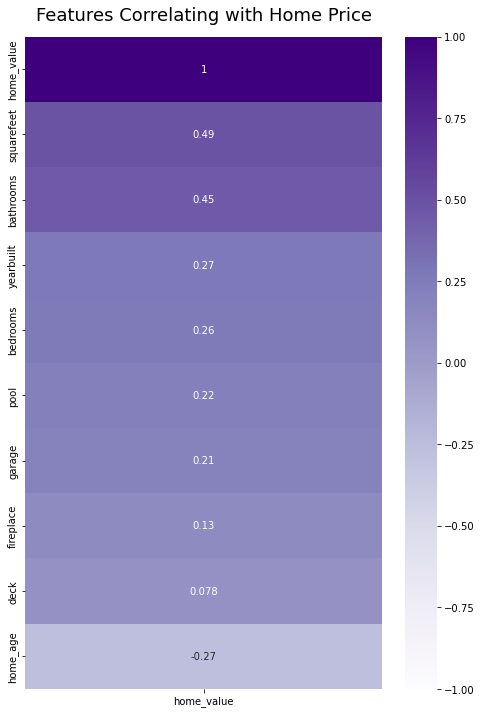

In [87]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr(method='spearman')[['home_value']].sort_values(by='home_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Purples')
heatmap.set_title('Features Correlating with Home Price', fontdict={'fontsize':18}, pad=16);

<div class="alert alert-info">Highest correlation seems to be squarefeet, bathrooms and yearbuilt

In [95]:
columns = train.columns.to_list()
columns

['squarefeet',
 'bathrooms',
 'bedrooms',
 'home_value',
 'yearbuilt',
 'fireplace',
 'deck',
 'pool',
 'garage',
 'home_age']

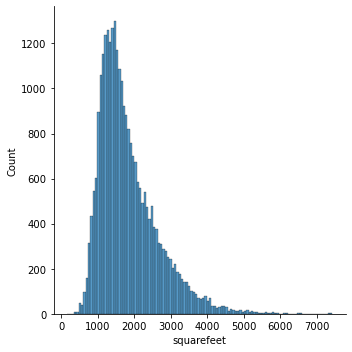

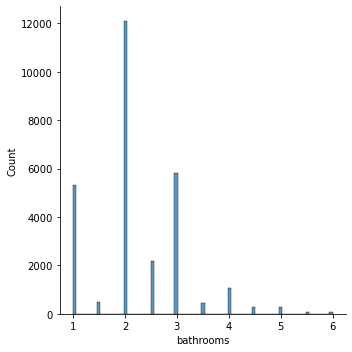

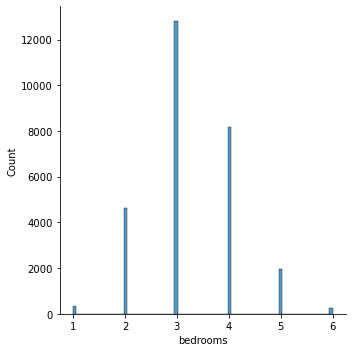

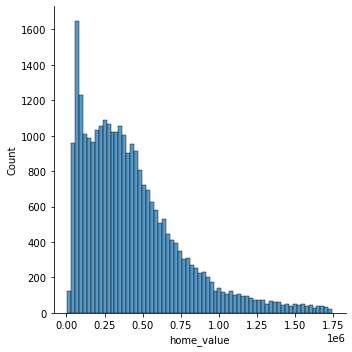

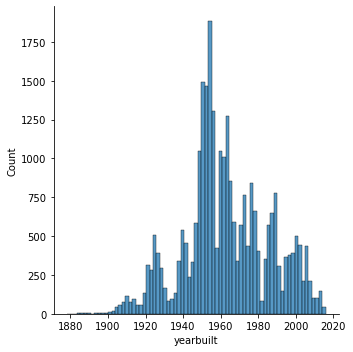

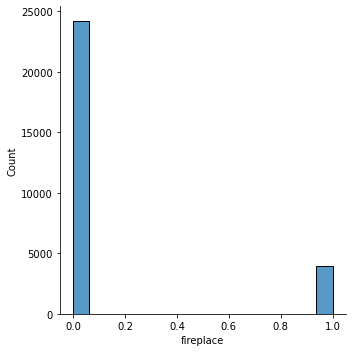

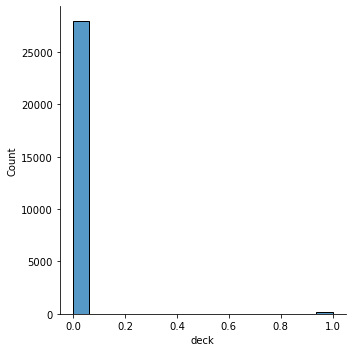

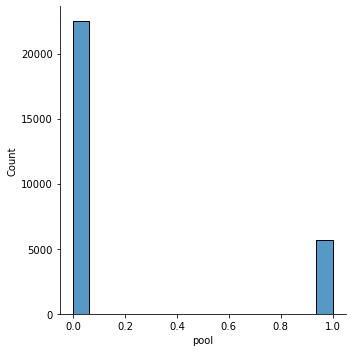

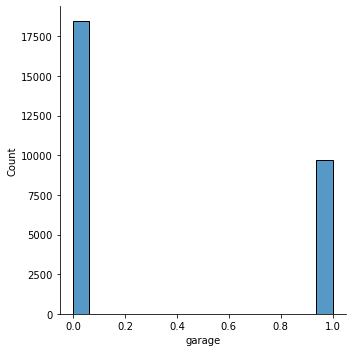

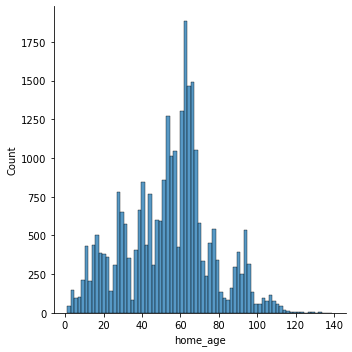

In [96]:
for i in columns:    
    sns.displot(train[i])

# Stats

In [ ]:
above_mean_bathrooms = train.bathrooms[train.bathrooms > train.bathrooms.mean()]
overall_mean = train.bathrooms.mean()

In [ ]:
alpha=0.05
t, p = stats.ttest_1samp(above_mean_bathrooms, overall_mean)

print(t, p/2)

In [ ]:
# pearsonr r for continuous variables
for i in cont_vars:
    α =0.05
    corr, p = stats.pearsonr(train[i], train.tax_value)
    print('_____________________________________________________')
    print('HYPOTHESIS')
    print(f'H0: There is no significant difference between tax_value in different {i}')
    print(f'Ha:(There is a significant difference between tax_value in different {i}')
    print(f'{i} correlation {corr}, p-val{p}')
    if p < α:
        print('We reject the null hypothesis.')
        print(f'There is a correlation between tax_value and {i}')
    else:
        print('We fail to reject the null hypothesis.')
        print(f'There is no correlation between tax_value and {i}')

In [ ]:
for i in cat_vars:
    α =0.05
    corr, p = stats.pearsonr(train[i], train.tax_value)
    print('_____________________________________________________')
    print('HYPOTHESIS')
    print(f'H0: There is no significant difference between tax_value in different {i}')
    print(f'Ha:(There is a significant difference between tax_value in different {i}')
    print(f'{i} correlation {corr}, p-val{p}')
    if p < α:
        print('We reject the null hypothesis.')
        print(f'There is a correlation between tax_value and {i}')
    else:
        print('We fail to reject the null hypothesis.')
        print(f'There is no correlation between tax_value and {i}')

# Model

### Scale Data

In [ ]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['bedrooms', 'bathrooms', 'squarefeet']):
    '''
    scale_data takes in train , validate, test data  and returns their scaled counterparts.
    '''
    # create copies of our original data
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #create the scaler
    scaler = QuantileTransformer(output_distribution='normal')
    # fit the scaler into train data
    scaler.fit(train[columns_to_scale])
    
    # applying the scaler to train, validate, and test data
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    return train_scaled, validate_scaled, test_scaled

In [ ]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(train,validate,test)

In [ ]:

# Setup X and y
X_train_scaled = X_train_scaled.drop(columns='tax_value')
y_train = train.tax_value

X_validate_scaled = X_validate_scaled.drop(columns='tax_value')
y_validate = validate.tax_value

X_test_scaled = X_test_scaled.drop(columns='tax_value')
y_test = test.tax_value

In [ ]:
# Turn everything into a dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(X_validate_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

### Select Features for model

In [ ]:
def select_Kbest(X, y, k=2):   
    '''
    select_Kbest takes in :
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of features
    
    returns: a list of the selected features using SelectBest 
    '''
    # model
    kbest = SelectKBest(f_regression, k=k)
    # fit
    kbest.fit(X, y)
    # mask of selection
    feature_mask = kbest.get_support()
    rank = X.columns[feature_mask]
    
    # convert to list
    rank = rank.to_list()


    return f'TOP {k} features: {rank}'

In [ ]:
select_Kbest(X_train_scaled,y_train, k=2)

### Simple model

In [ ]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
}) 

In [ ]:
# X must be 2-d array
#X_train_scaled = X_train_scaled[['bathrooms']]
# y can be 1-d array
#y_train = train.tax_value

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train_scaled[['bathrooms']], y_train)
# 3. use the thing (make predictions)
#X_validate = validate[['taxamount']]
predictions['simple_lm'] = lm.predict(X_validate[['bathrooms']])

In [ ]:
# look into modesl make up 
lm.coef_, lm.intercept_

In [ ]:
print(f'tax_value = {lm.coef_}*bathrooms + {lm.intercept_}')

In [ ]:
predictions

### Multiple + RFE

In [ ]:
def rfe(X, y, k=2):
    ''' 
    rfe takes in:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of features
    
    returns: a list of the selected features using RFE
    '''
    # Model
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select= k)
    #fit
    rfe.fit(X, y)
    # mask selection
    mask = rfe.get_support()
    
    return X.columns[mask]

In [ ]:
rfe(X_train_scaled, y_train, k=2)

In [ ]:


lm = LinearRegression()
k = 2

### 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)
print('selected top 2 features:', X_train_scaled.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train_scaled)

In [ ]:
# 1. Transform our X
X_train_rfe = rfe.transform(X_train_scaled)
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

In [ ]:
# look into models make up
lm.coef_, lm.intercept_

In [ ]:
print(f'tax_value = {lm.coef_[0]:.2f} x squarefeet + {lm.coef_[1]:.2f} x bedroom + {lm.intercept_:.2f}')

### Poly Degree2

In [ ]:
# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train_scaled)
X_train_poly = pd.DataFrame(
    poly.transform(X_train_scaled),
    columns=poly.get_feature_names(X_train_scaled.columns),
    index=train.index,
)
X_train_poly.head()

In [ ]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate_scaled)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)
predictions

# Poly interactions_only 

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train_scaled)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate_scaled)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train_scaled.columns)).sort_values()

In [ ]:
predictions

## Laso Lars

In [ ]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

In [ ]:
predictions

# GLM

In [ ]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train_scaled, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate_scaled)

# Add lassolars predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

### Baseline

In [ ]:
# add a baseline model
predictions['baseline'] = train.tax_value.mean()

In [ ]:
predictions

# Evaluate

In [ ]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
def calculate_RMSE(y_predicted):
    return mean_squared_error(predictions.acual,y_predicted)
predictions.apply(calculate_mse).sort_values()**.5

First itteration of models Polynomial degree2 was best, Then glm, then lasso_lars then baseline